In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import mglearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [54]:
data = pd.read_csv("Energi_Viborg_Dandas_data.csv")

In [55]:
#drop columns not needed after asking the company about the meaning of these features

columns_to_be_removed = ['ID', 'mslink', 'XKoordinat','YKoordinat','LedningID','Dobbeltled','EjerKompon','SystemKode','KategoriAf','DatoUdf']
data=data.drop(columns_to_be_removed,axis='columns')

In [56]:
# in the column DatoSaneri is the date of repairing and if there is no date it means it is not repaired

data['DatoSaneri'].fillna(0, inplace=True)

In [57]:
# take only the pipes that are broken(by TV insection) now and the repaired ones

data_with_TVObsAndSaneri = data[data['TVObsKode'].isin([1]) | data['DatoSaneri'] > 0]

In [58]:
#get around 2077 rows with not broken pipes

data_not_broken = data[~data['TVObsKode'].isin([0]) | data['DatoSaneri'] == 0]
data_not_broken = data_not_broken.sample(n=2077) 

In [59]:
frames = [data_with_TVObsAndSaneri, data_not_broken]
  
data_final = pd.concat(frames)
data_final

,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoOprett,DatoOpdate,DatoSaneri
36,34.72,33.48,64.88,19.112207,300.0,1.0,1939.0,1,0,0.0,2010,2014,1997.0
42,39.46,39.16,91.75,3.269755,400.0,1.0,1939.0,1,0,1.0,2010,2014,0.0
43,39.71,39.48,87.69,2.622876,300.0,1.0,1939.0,1,0,1.0,2010,2014,0.0
64,40.55,40.08,52.11,9.019382,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0
65,40.38,40.55,68.39,-2.485744,250.0,1.0,1945.0,1,0,1.0,2010,2014,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,27.23,27.12,70.10,1.569187,600.0,1.0,1975.0,1,0,0.0,2010,2014,0.0
1240,33.56,33.22,35.35,9.618105,300.0,1.0,1977.0,1,0,0.0,2010,2014,0.0
23986,7.89,6.86,70.71,14.566539,200.0,4.0,1991.0,1,0,0.0,2018,2018,0.0
751,12.55,12.21,49.02,6.935945,250.0,1.0,1969.0,1,0,0.0,2010,2014,0.0


In [60]:
data = data_final

In [61]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(data.shape[0]))
data = data.dropna()
print("Number of rows after removing NaNs: {}".format(data.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


In [62]:
#get data copied
datacopy = data


# add  age column

#get current year
from datetime import date
now = date.today().year


def age_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] > 0) :
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return (now - datacopy['DatoSaneri'])
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return (now - datacopy['anlag_aar'])

datacopy['Age'] = datacopy.apply(age_df, axis = 1)

In [63]:
# add a column 'PipeStatus'
# 1 as broken and 0 as not broken

def broken_df(datacopy):

    if (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] < (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 1
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri'] >= (datacopy['DatoOpdate'])) and (datacopy['DatoSaneri'] != 0):
        return 0
    elif (datacopy['TVObsKode'] == 1) and (datacopy['DatoSaneri']== 0):
        return 1
    elif (datacopy['TVObsKode'] == 0) and (datacopy['DatoSaneri'] > 0):
        return 0
    elif (datacopy['TVObsKode']== 0) and (datacopy['DatoSaneri']== 0):
        return 0

datacopy['PipeStatus'] = datacopy.apply(broken_df, axis = 1)

In [64]:
# datacopy = datacopy.sample(n=22) 
# datacopy

In [65]:
# data_fs= np.where(np.isnan(datacopy))
# data_fs
# row = datacopy.iloc[369] #index=1 => second row
# print(row)

In [66]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(datacopy.shape[0]))
datacopy = datacopy.dropna()
print("Number of rows after removing NaNs: {}".format(datacopy.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


In [67]:
#drop columns not needed after adding new features

columns_to_be_removed = ['DatoOprett', 'DatoOpdate']
datacopy=datacopy.drop(columns_to_be_removed,axis='columns')
datacopy[0:-1]

,fra_kote,til_kote,Laengde,Fald,DiameterIn,MaterialeK,anlag_aar,TransportK,Funktionsk,TVObsKode,DatoSaneri,Age,PipeStatus
36,34.72,33.48,64.88,19.112207,300.0,1.0,1939.0,1,0,0.0,1997.0,24.0,0
42,39.46,39.16,91.75,3.269755,400.0,1.0,1939.0,1,0,1.0,0.0,82.0,1
43,39.71,39.48,87.69,2.622876,300.0,1.0,1939.0,1,0,1.0,0.0,82.0,1
64,40.55,40.08,52.11,9.019382,250.0,1.0,1945.0,1,0,1.0,0.0,76.0,1
65,40.38,40.55,68.39,-2.485744,250.0,1.0,1945.0,1,0,1.0,0.0,76.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553,51.65,50.40,34.79,35.929865,250.0,1.0,1976.0,1,0,0.0,0.0,45.0,0
2932,27.23,27.12,70.10,1.569187,600.0,1.0,1975.0,1,0,0.0,0.0,46.0,0
1240,33.56,33.22,35.35,9.618105,300.0,1.0,1977.0,1,0,0.0,0.0,44.0,0
23986,7.89,6.86,70.71,14.566539,200.0,4.0,1991.0,1,0,0.0,0.0,30.0,0


In [68]:
# creating features set and target

columns_to_be_removed = ['PipeStatus']
data_features= datacopy.drop(columns_to_be_removed,axis='columns')
columns_to_be_removed = ['fra_kote','til_kote', 'Laengde','Fald','DiameterIn','MaterialeK','anlag_aar','TransportK','Funktionsk','TVObsKode','DatoSaneri','Age']
data_target=datacopy.drop(columns_to_be_removed,axis='columns')

In [69]:
# data_fs= np.where(np.isnan(data_features))
# data_fs
print("Number of rows before removing NaNs: {}".format(data.shape[0]))
data = data.dropna()
print("Number of rows after removing NaNs: {}".format(data.shape[0]))

Number of rows before removing NaNs: 4154
Number of rows after removing NaNs: 4154


# Finding the best number of neighbours by test-set

In [70]:
# Divide the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, stratify=data_target, random_state=42)

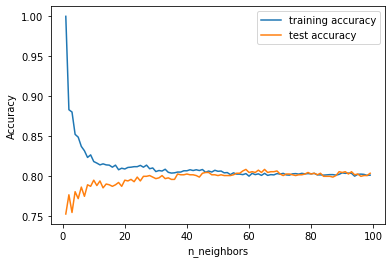

In [71]:
training_accuracy = []
test_accuracy = []


# try n_neighbors from 1 to 100

neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend();

# Finding the best number of neighbours by validation set

In [72]:
# Divide the data into training, test and validation

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=43)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of validation set:{}".format(X_val.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:2336
Size of validation set:779
Size of test set:1039


In [73]:
best_score = 0
for num_neighbors in range(1,100):
    # Learn the model with a certain numnber of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(X_train, y_train)
    
    # Evaluate the model
    score = knn.score(X_val, y_val)
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best score on validation set: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test, y_test)))

Best number of neighbors found: 25
Best score on validation set: 0.8331193838254172
Score on training/validation set: 0.8131621187800963
Score on test set: 0.7940327237728585


# Finding the best number of neighbours by cross validation

In [74]:
# Divide the data into training and test , no validation data

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:2336
Size of test set:1039


In [75]:
best_score = 0
for num_neighbors in range(1,100):
    # Set a certain number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    
    # Perform cross validation
    scores = cross_val_score(knn, X_trainval, y_trainval, cv=5)
    
    # Compute the mean score
    score = scores.mean()
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test, y_test)))

Best number of neighbors found: 39
Best average score: 0.8044943820224718
Score on training/validation set: 0.8086677367576244
Score on test set: 0.8017324350336862


# Finding the best number of neighbours by cross validation(leave one out)

In [76]:
loo = LeaveOneOut()
best_score = 0
for num_neighbors in range(1,100):
    # Set a certain number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    
    # Perform leave-one-out cross ("loo") validation
    scores = cross_val_score(knn, X_trainval, y_trainval, cv=loo) 
    
    # Compute the mean score
    score = scores.mean()
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test, y_test)))

Best number of neighbors found: 13
Best average score: 0.8041733547351525
Score on training/validation set: 0.8253611556982343
Score on test set: 0.7892204042348412


# Finding k with test-set and normalization

In [77]:
# Divide the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, stratify=data_target, random_state=42)

# preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


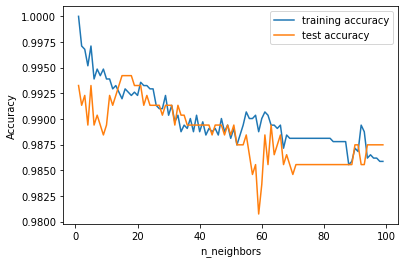

In [78]:
training_accuracy = []
test_accuracy = []


# try n_neighbors from 1 to 100

neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_scaled, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train_scaled, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test_scaled, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend();

# Finding k with test-set and standardization

In [79]:
# Divide the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, stratify=data_target, random_state=42)

# preprocessing using zero mean and unit variance scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


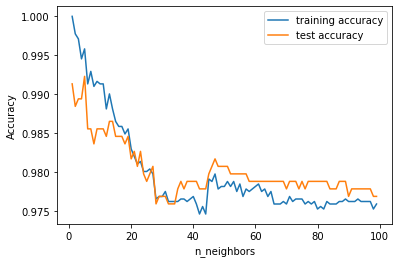

In [80]:
training_accuracy = []
test_accuracy = []


# try n_neighbors from 1 to 100

neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_scaled, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train_scaled, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test_scaled, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend();

# Finding k with validation set and normalization

In [81]:
# Divide the data into training, test and validation

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=43)

# preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_trainval_scaled = scaler.transform( X_trainval)

print("Size of training set:{}".format(X_train_scaled.shape[0]))
print("Size of validation set:{}".format(X_val_scaled.shape[0]))
print("Size of test set:{}".format(X_test_scaled.shape[0]))

Size of training set:2336
Size of validation set:779
Size of test set:1039


In [82]:
best_score = 0
for num_neighbors in range(1,70):
    # Learn the model with a certain numnber of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    score = knn.score(X_val_scaled, y_val)
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval_scaled, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best score on validation set: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval_scaled, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test_scaled, y_test)))

Best number of neighbors found: 2
Best score on validation set: 0.9948652118100129
Score on training/validation set: 0.9964686998394864
Score on test set: 0.9932627526467758


# Finding k with validation set and standardization

In [83]:
# Divide the data into training, test and validation

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=43)

# preprocessing using zero mean and unit variance scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_trainval_scaled = scaler.transform( X_trainval)

print("Size of training set:{}".format(X_train_scaled.shape[0]))
print("Size of validation set:{}".format(X_val_scaled.shape[0]))
print("Size of test set:{}".format(X_test_scaled.shape[0]))

Size of training set:2336
Size of validation set:779
Size of test set:1039


In [84]:
best_score = 0
for num_neighbors in range(1,70):
    # Learn the model with a certain numnber of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    score = knn.score(X_val_scaled, y_val)
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval_scaled, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best score on validation set: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval_scaled, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test_scaled, y_test)))

Best number of neighbors found: 2
Best score on validation set: 0.9922978177150192
Score on training/validation set: 0.9955056179775281
Score on test set: 0.9961501443695862


# Finding the best number of neighbours by cross validation + normalization

In [85]:
# Divide the data into training and test , no validation data

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)

# preprocessing using 0-1 scaling
scaler = MinMaxScaler()
scaler.fit(X_train)

X_test_scaled = scaler.transform(X_test)
X_trainval_scaled = scaler.transform( X_trainval)


print("Size of training set:{}".format(X_trainval_scaled.shape[0]))
print("Size of test set:{}".format(X_test_scaled.shape[0]))

Size of training set:3115
Size of test set:1039


In [86]:
best_score = 0
for num_neighbors in range(1,70):
    # Set a certain number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    
    # Perform cross validation
    scores = cross_val_score(knn, X_trainval_scaled, y_trainval, cv=5)
    
    # Compute the mean score
    score = scores.mean()
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval_scaled, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test_scaled, y_test)))

Best number of neighbors found: 1
Best average score: 0.9932584269662922
Score on training/validation set: 0.78330658105939
Score on test set: 0.9932627526467758


# Finding the best number of neighbours by cross validation + standardization

In [87]:
# Divide the data into training and test , no validation data

X_trainval, X_test, y_trainval, y_test = train_test_split(data_features, data_target, random_state=42)

# preprocessing using zero mean and unit variance scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_test_scaled = scaler.transform(X_test)
X_trainval_scaled = scaler.transform( X_trainval)


print("Size of training set:{}".format(X_trainval_scaled.shape[0]))
print("Size of test set:{}".format(X_test_scaled.shape[0]))

Size of training set:3115
Size of test set:1039


In [88]:
best_score = 0
for num_neighbors in range(1,70):
    # Set a certain number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    
    # Perform cross validation
    scores = cross_val_score(knn, X_trainval_scaled, y_trainval, cv=5)
    
    # Compute the mean score
    score = scores.mean()
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors

# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval_scaled, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test_scaled, y_test)))

Best number of neighbors found: 1
Best average score: 0.9913322632423757
Score on training/validation set: 0.7823434991974317
Score on test set: 0.9961501443695862


# Removing Outliers

In [89]:
# copy the data before remove the outliers
dataNoOutliers = datacopy

In [90]:
#To sum how many outliers in all features.
Q1 = dataNoOutliers.quantile(0.25)
Q3 = dataNoOutliers.quantile(0.75)
IQR = Q3 - Q1     #IQR is interquartile range.
((dataNoOutliers < (Q1 - 1.5 * IQR)) |(dataNoOutliers > (Q3 + 1.5 * IQR))).sum()

# remove, keep or replace outliers

fra_kote        4
til_kote        5
Laengde        83
Fald          425
DiameterIn    393
MaterialeK     51
anlag_aar      11
TransportK      0
Funktionsk    126
TVObsKode     935
DatoSaneri      0
Age             0
PipeStatus    883
dtype: int64

In [91]:
# removing outliers but the code is not working 

print("Number of rows before applying filter: {}".format(dataNoOutliers.shape[0]))

dataNoOutliers = dataNoOutliers[dataNoOutliers >= Q1-1.5*IQR]
dataNoOutliers = dataNoOutliers[dataNoOutliers <= Q3+1.5*IQR]
print("Number of rows after applying filter: {}".format(dataNoOutliers.shape[0]))

Number of rows before applying filter: 4154
Number of rows after applying filter: 4154
